1. Importing Libraries:

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,GRU, Dropout,LSTM
from sklearn.metrics import mean_absolute_error, mean_squared_error
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose

2. Loading and Preprocessing Data:

In [24]:
model_type = 'LSTM'  # Set to 'LSTM' for LSTM or 'GRU' for GRU
nifty_it = yf.download('^CNXIT', start='2010-01-01', end='2024-11-10', interval='1d')
nifty_it = nifty_it[['Close']].fillna(method='ffill')

nifty_it.tail()

[*********************100%%**********************]  1 of 1 completed


c:\ProgramData\anaconda3\envs\deeptrend\Lib\site-packages\yfinance\utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\Krunal Shambharkar\AppData\Local\Temp\ipykernel_4780\3651307684.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nifty_it = nifty_it[['Close']].fillna(method='ffill')


,Close
Date,
2024-11-04,40421.800781
2024-11-05,40424.601562
2024-11-06,42039.500000
2024-11-07,41752.398438
2024-11-08,42050.148438


3. Exploratory Data Analysis (EDA):

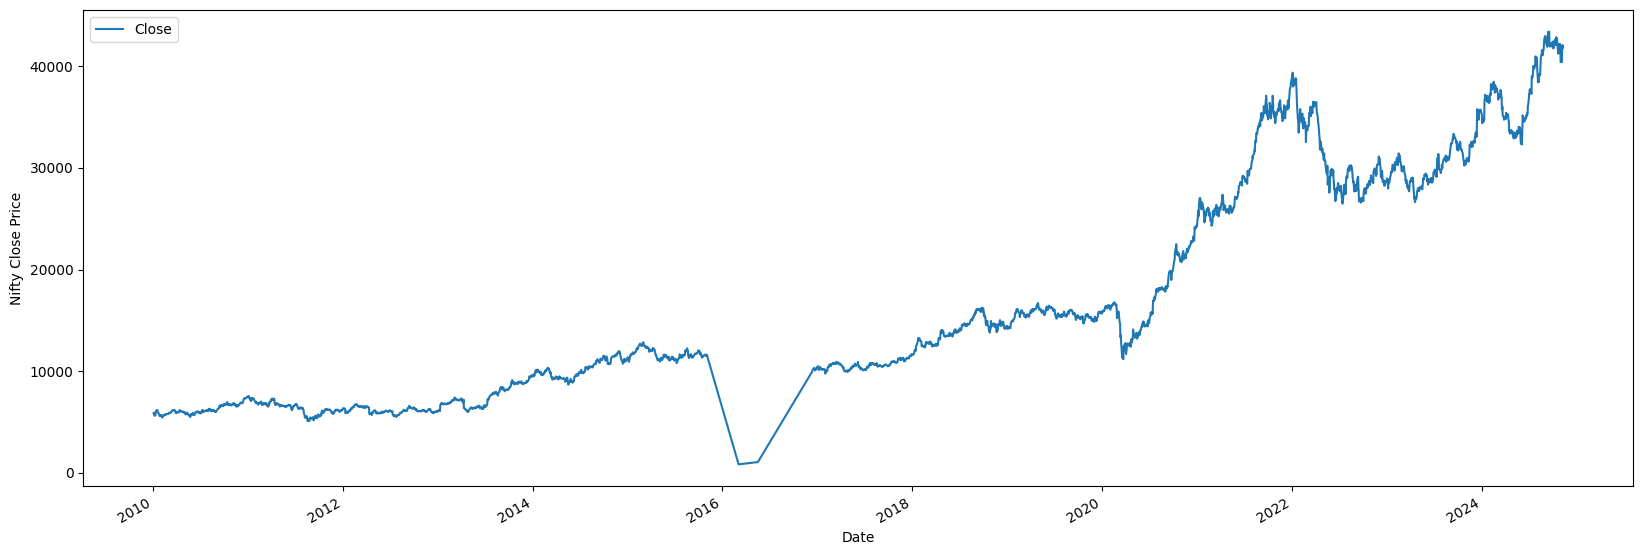

In [25]:
nifty_it.plot(figsize=(20,7))
plt.xlabel('Date')
plt.ylabel(f'Nifty Close Price')
plt.show()

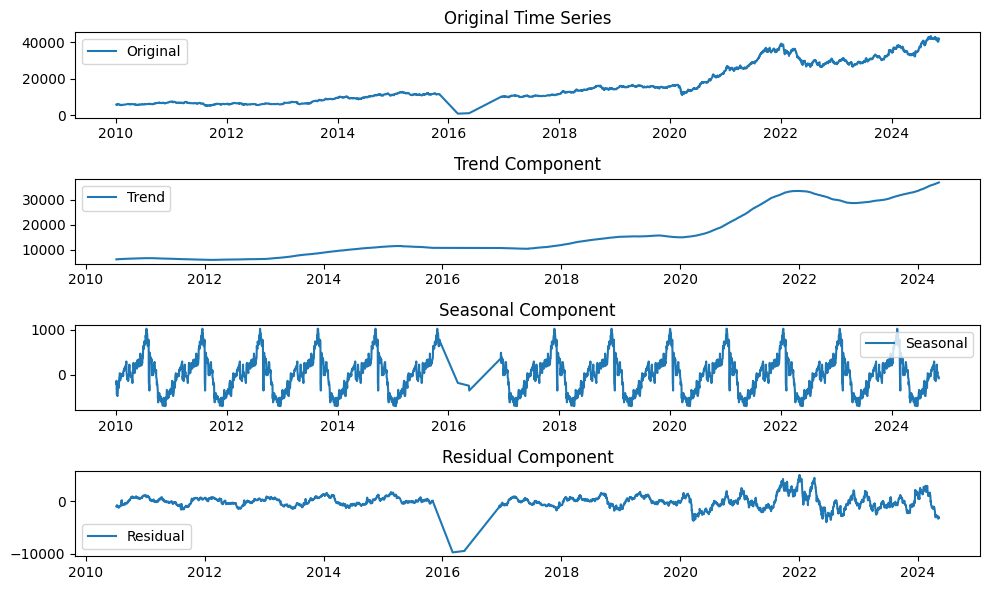

In [26]:
# Apply seasonal decomposition on the data

results = seasonal_decompose(nifty_it['Close'], model='additive', period=253)

# Plot the original, trend, seasonal, and residual components
plt.figure(figsize=(10, 6))

# Original time series
plt.subplot(4, 1, 1)
plt.plot(nifty_it['Close'], label='Original')
plt.legend()
plt.title('Original Time Series')

# Trend component
plt.subplot(4, 1, 2)
plt.plot(results.trend, label='Trend')
plt.legend()
plt.title('Trend Component')

# Seasonal component
plt.subplot(4, 1, 3)
plt.plot(results.seasonal, label='Seasonal')
plt.legend()
plt.title('Seasonal Component')

# Residual component
plt.subplot(4, 1, 4)
plt.plot(results.resid, label='Residual')
plt.legend()
plt.title('Residual Component')

plt.tight_layout()
plt.show()

4. Train-Test Split and Scaling

In [27]:
"""**4. Train-Test Split and Scaling**"""

# Get user input for the date
while True:
    try:
        split_date_str = input("Enter the split date (YYYY-MM-DD): ")
        split_date = pd.to_datetime(split_date_str)
        break
    except ValueError:
        print("Invalid date format. Please use YYYY-MM-DD.")

# Train-test split based on the input date
train = nifty_it[nifty_it.index <= split_date]
test = nifty_it[nifty_it.index > split_date]

# Check if there is enough data for 30 days of predictions
if len(test) < 30:
    print("Warning: Not enough data for 30 days of predictions. Predicting for available data.")
    prediction_length = len(test)
else:
    prediction_length = 30
    test = test.iloc[:30]

# Scaling
scaler = MinMaxScaler()
scaler.fit(nifty_it)
scaled_train = scaler.transform(train).flatten().tolist()
scaled_test = scaler.transform(test).flatten().tolist()

**5. Data Preparation for LSTM**

In [28]:
# Reshape data for LSTM
def create_sequences(data, n_input):
    X, y = [], []
    for i in range(len(data) - n_input):
        X.append(data[i:i + n_input])
        y.append(data[i + n_input])
    return np.array(X), np.array(y)

n_input = 3
X_train, y_train = create_sequences(scaled_train, n_input)
X_test, y_test = create_sequences(scaled_test, n_input)

6. Building the LSTM/GRU Model

In [29]:
model_type = 'GRU'  # Set to 'LSTM' for LSTM or 'GRU' for GRU

In [30]:
if model_type == 'LSTM':
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(n_input, 1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=64))
    model.add(Dropout(0.2))

    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
elif model_type == 'GRU':
    # Build the GRU model
    model = Sequential()
    model.add(GRU(64, return_sequences=True, input_shape=(n_input, 1)))
    model.add(Dropout(0.2))

    model.add(GRU(units=64, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(GRU(units=64))
    model.add(Dropout(0.1))

    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mae')
else:
    print("Invalid model type. Please choose 'LSTM' or 'GRU'.")

7. Training the Model

In [31]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
45/45 [==============================] - 4s 4ms/step - loss: 0.0383
Epoch 2/20
45/45 [==============================] - 0s 5ms/step - loss: 0.0116
Epoch 3/20
45/45 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 4/20
45/45 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 5/20
45/45 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 6/20
45/45 [==============================] - 0s 5ms/step - loss: 0.0087
Epoch 7/20
45/45 [==============================] - 0s 5ms/step - loss: 0.0085
Epoch 8/20
45/45 [==============================] - 0s 5ms/step - loss: 0.0078
Epoch 9/20
45/45 [==============================] - 0s 5ms/step - loss: 0.0075
Epoch 10/20
45/45 [==============================] - 0s 5ms/step - loss: 0.0073
Epoch 11/20
45/45 [==============================] - 0s 4ms/step - loss: 0.0074
Epoch 12/20
45/45 [==============================] - 0s 5ms/step - loss: 0.0077
Epoch 13/20
45/45 [==============================

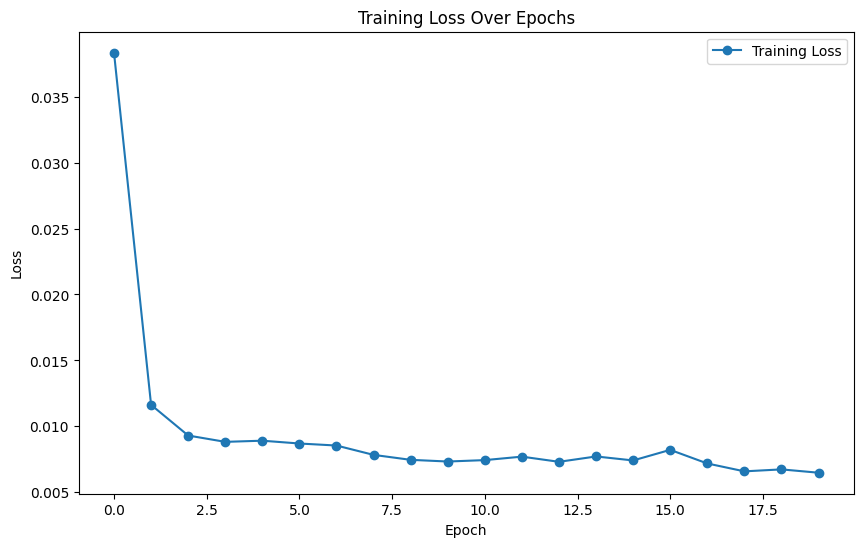

In [32]:
# Extract training loss from the history
train_loss_history = history.history['loss']

# Plot the training loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Training Loss', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

9. Model Evaluation and Prediction

In [33]:
# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Training Loss: {train_loss}')
print(f'Testing Loss: {test_loss}')

1/1 [==============================] - 0s 15ms/step
Training Loss: 0.0028345801401883364
Testing Loss: 0.00219448353163898


In [34]:
# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAE, MSE, MAPE for training set
train_mae = mean_absolute_error(y_train, train_predict)
train_mape = np.mean(np.abs((y_train - train_predict) / y_train)) * 100

print(f'Training MAE: {train_mae:.4f}')
print(f'Training MAPE: {train_mape:.4f}%')

# Calculate MAE, MSE, MAPE for testing set
test_mae = mean_absolute_error(y_test, test_predict)
test_mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100

print(f'Testing MAE: {test_mae:.4f}')
print(f'Testing MAPE: {test_mape:.4f}%')

Training MAE: 120.7106
Training MAPE: 3.0669%
Testing MAE: 93.4523
Testing MAPE: 0.9141%


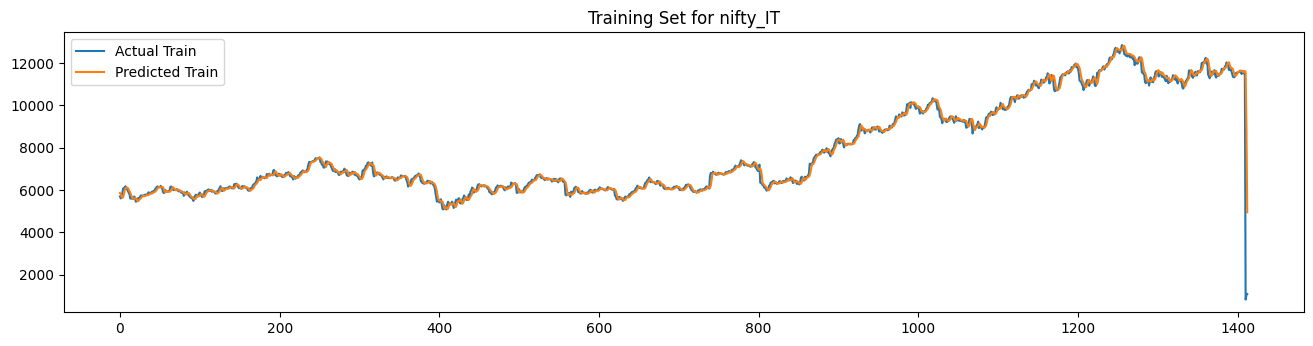

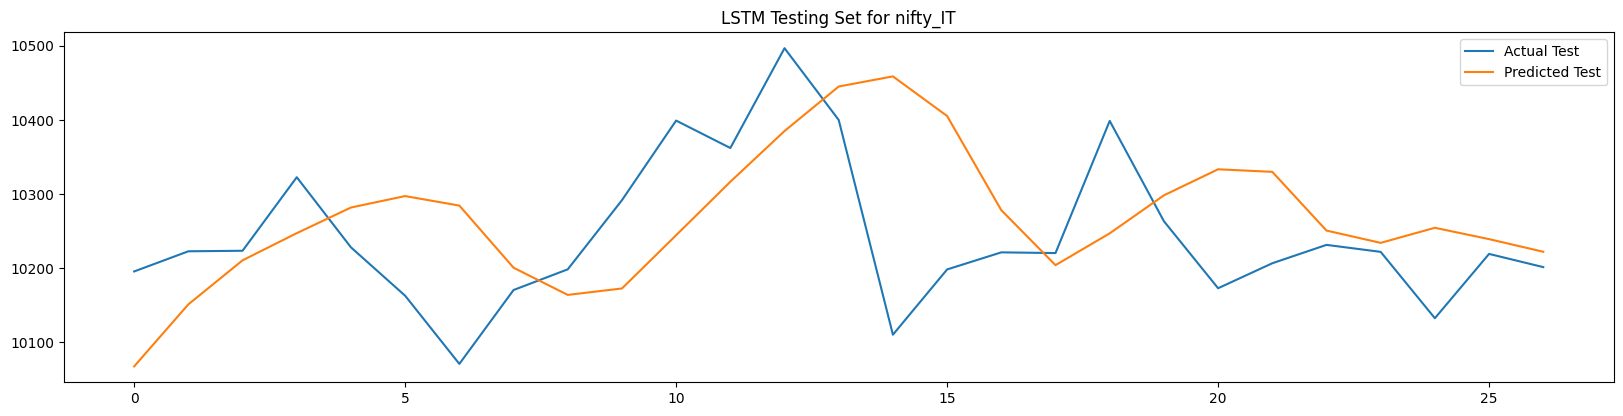

In [35]:
# Plot predictions
plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
plt.plot(y_train, label='Actual Train')
plt.plot(train_predict, label='Predicted Train')
plt.title(f'Training Set for nifty_IT')
plt.legend()

plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 2)
plt.plot(y_test, label='Actual Test')
plt.plot(test_predict, label='Predicted Test')
plt.title(f'LSTM Testing Set for nifty_IT')
plt.legend()

plt.show()